In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm.notebook import tqdm
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# Load semantic model
# The SemanticModel class is something I wrote to make it easy to deal with vector-space semantic models.
from SemanticModel import SemanticModel
eng1000 = SemanticModel.load("data/english1000sm.hf5")

In [3]:

# These are lists of the stories
# Rstories are the names of the training (or Regression) stories, which we will use to fit our models
Rstories = ['alternateithicatom', 'avatar', 'howtodraw', 'legacy', 
            'life', 'myfirstdaywiththeyankees', 'naked', 
            'odetostepfather', 'souls', 'undertheinfluence']

# Pstories are the test (or Prediction) stories (well, story), which we will use to test our models
Pstories = ['wheretheressmoke']

allstories = Rstories + Pstories

# Load TextGrids
from stimulus_utils import load_grids_for_stories
grids = load_grids_for_stories(allstories)

# Load TRfiles
from stimulus_utils import load_generic_trfiles
trfiles = load_generic_trfiles(allstories)

# Make word and phoneme datasequences
from dsutils import make_word_ds, make_phoneme_ds
wordseqs = make_word_ds(grids, trfiles) # dictionary of {storyname : word DataSequence}
phonseqs = make_phoneme_ds(grids, trfiles) # dictionary of {storyname : phoneme DataSequence}

In [4]:

naked = wordseqs["naked"]
# The DataSequence stores a lot of information
# naked.data is a list of all the words in the story
print ("There are %d words in the story called 'naked'" % len(list(naked.data)))

There are 3218 words in the story called 'naked'


In [5]:

# Project stimuli
from dsutils import make_semantic_model
semanticseqs = dict() # dictionary to hold projected stimuli {story name : projected DataSequence}
for story in allstories:
    semanticseqs[story] = make_semantic_model(wordseqs[story], eng1000)

In [6]:

# take a look at the projected stimuli
naked_proj = semanticseqs["naked"]

print (naked_proj.data.shape) # prints the shape of 'data' as (rows, columns)
print (naked_proj.data[:10]) # print the first 10 rows (this will be truncated)

(3218, 985)
[[-0.48074415  0.10393176 -0.45596143 ... -0.03175243 -0.62248756
  -0.32170921]
 [ 0.09911849  0.06500191 -0.78847992 ...  1.95413789 -0.94043714
  -1.0863888 ]
 [-0.73058513 -0.37099858 -0.59858174 ... -0.30655477 -0.30774183
  -0.66815734]
 ...
 [ 0.59646679  0.31843488  0.78981277 ...  0.21670864 -1.09263289
  -1.26290446]
 [-0.61541241 -1.1005762  -0.33248156 ...  0.23637707 -1.5470721
  -0.6521566 ]
 [ 0.3866531  -0.05810349 -0.63087673 ...  0.43836955 -1.03314247
  -0.57172974]]


In [7]:

# Downsample stimuli
interptype = "lanczos" # filter type
window = 3 # number of lobes in Lanczos filter

downsampled_semanticseqs = dict() # dictionary to hold downsampled stimuli
for story in allstories:
    downsampled_semanticseqs[story] = semanticseqs[story].chunksums(interptype, window=window)

Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.


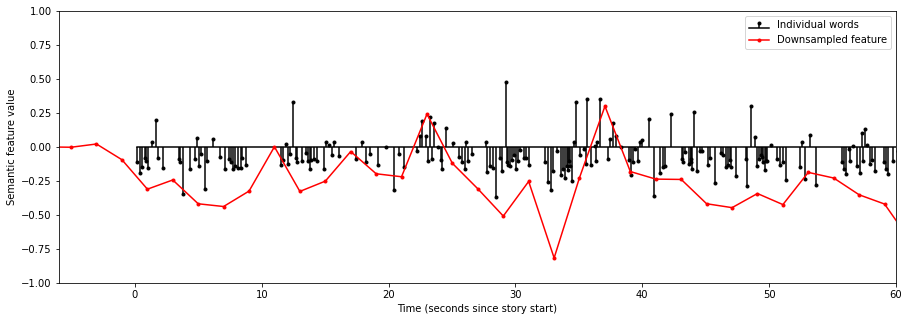

In [8]:

# Plot the result
s_words = wordseqs["naked"]
s_sem = semanticseqs["naked"]
s_semdown = downsampled_semanticseqs["naked"]

f = plt.figure(figsize=(15,5))
f.clf()
schan = 2
ax = f.add_subplot(1,1,1)
wordstems = ax.stem(s_sem.data_times, 
                    s_sem.data[:,schan] / np.abs(s_sem.data[:,schan]).max(), 
                    linefmt="k-", markerfmt="k.", basefmt="k-")
interps = ax.plot(s_sem.tr_times, 
                  s_semdown[:,schan] / np.abs(s_semdown[:,schan]).max(), 'r.-')
ax.set_xlim(-6, 60)
ax.set_ylim(-1, 1)
ax.set_xlabel("Time (seconds since story start)")
ax.set_ylabel("Semantic feature value")
ax.legend((wordstems, interps[0]), ("Individual words", "Downsampled feature"));

In [9]:

# Combine stimuli
from npp import zscore
trim = 5
Rstim = np.vstack([zscore(downsampled_semanticseqs[story][5+trim:-trim]) for story in Rstories])
Pstim = np.vstack([zscore(downsampled_semanticseqs[story][5+trim:-trim]) for story in Pstories])

In [10]:

storylens = [len(downsampled_semanticseqs[story][5+trim:-trim]) for story in Rstories]
print(storylens)

print(np.cumsum(storylens))

[343, 367, 354, 400, 430, 358, 422, 404, 355, 304]
[ 343  710 1064 1464 1894 2252 2674 3078 3433 3737]


In [11]:

# Delay stimuli
from util import make_delayed
ndelays = 4
delays = range(1, ndelays+1)

print ("FIR model delays: ", delays)

delRstim = make_delayed(Rstim, delays)
delPstim = make_delayed(Pstim, delays)

FIR model delays:  range(1, 5)


In [12]:

# Load responses
import tables
resptf = tables.open_file("data/fmri-responses.hf5")
zRresp = resptf.root.zRresp.read()
zPresp = resptf.root.zPresp.read()
mask = resptf.root.mask.read()

In [13]:

# Run regression
from ridge import bootstrap_ridge
alphas = np.logspace(1, 3, 10) # Equally log-spaced alphas between 10 and 1000. The third number is the number of alphas to test.
nboots = 1 # Number of cross-validation runs.
chunklen = 40 # 
nchunks = 20

wt, corr, alphas, bscorrs, valinds = bootstrap_ridge(delRstim, zRresp, delPstim, zPresp,
                                                     alphas, nboots, chunklen, nchunks,
                                                     singcutoff=1e-10, single_alpha=True)

In [14]:

# Then let's predict responses by taking the dot product of the weights and stim
pred = np.dot(delPstim, wt)

print ("pred has shape: ", pred.shape)

pred has shape:  (291, 37226)


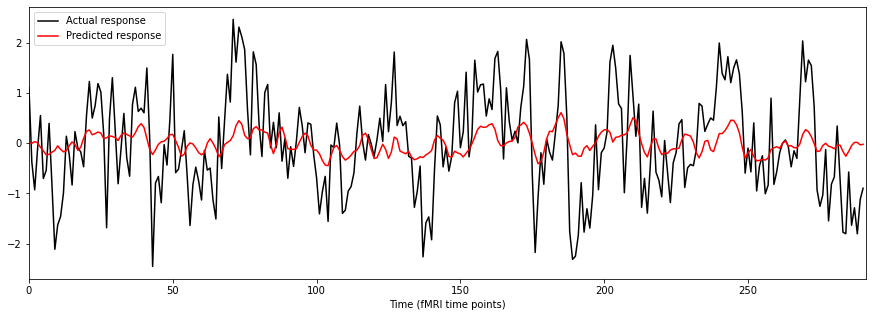

In [15]:

f = plt.figure(figsize=(15,5))
ax = f.add_subplot(1,1,1)

selvox = 20710 # a decent voxel

realresp = ax.plot(zPresp[:,selvox], 'k')[0]
predresp = ax.plot(pred[:,selvox], 'r')[0]

ax.set_xlim(0, 291)
ax.set_xlabel("Time (fMRI time points)")

ax.legend((realresp, predresp), ("Actual response", "Predicted response"));

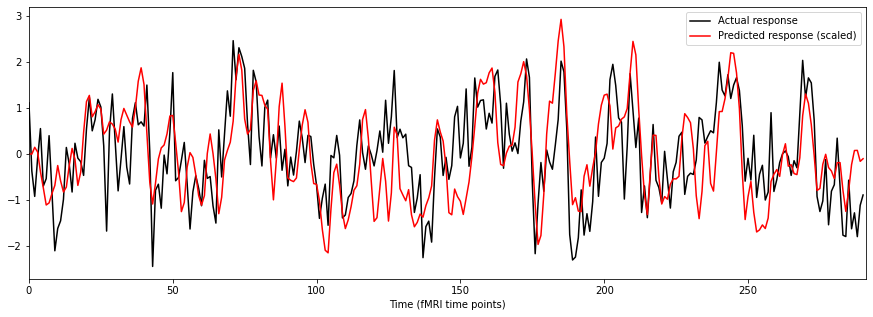

In [16]:

f = plt.figure(figsize=(15,5))
ax = f.add_subplot(1,1,1)

selvox = 20710 # a good voxel

realresp = ax.plot(zPresp[:,selvox], 'k')[0]
predresp = ax.plot(zscore(pred[:,selvox]), 'r')[0]

ax.set_xlim(0, 291)
ax.set_xlabel("Time (fMRI time points)")

ax.legend((realresp, predresp), ("Actual response", "Predicted response (scaled)"));

In [17]:

# Compute correlation between single predicted and actual response
# (np.corrcoef returns a correlation matrix; pull out the element [0,1] to get 
# correlation between the two vectors)
voxcorr = np.corrcoef(zPresp[:,selvox], pred[:,selvox])[0,1]
print ("Correlation between predicted and actual responses for voxel %d: %f" % (selvox, voxcorr))

Correlation between predicted and actual responses for voxel 20710: 0.580637


[ 0.02871944 -0.04650024 -0.04304503 ... -0.06272029  0.02739701
 -0.03342233]


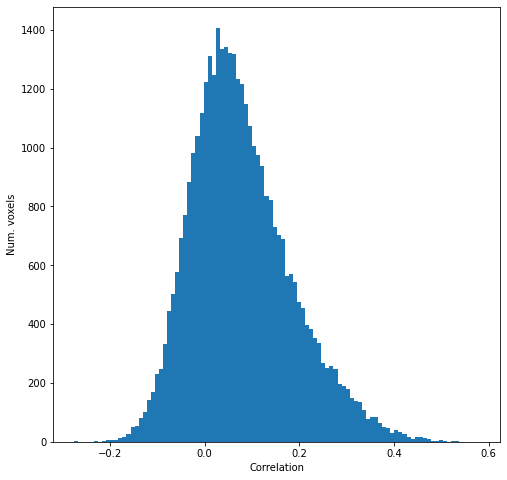

In [18]:

voxcorrs = np.zeros((zPresp.shape[1],)) # create zero-filled array to hold correlations
for vi in range(zPresp.shape[1]):
    voxcorrs[vi] = np.corrcoef(zPresp[:,vi], pred[:,vi])[0,1]
print (voxcorrs)

# Plot histogram of correlations
f = plt.figure(figsize=(8,8))
ax = f.add_subplot(1,1,1)
ax.hist(voxcorrs, 100) # histogram correlations with 100 bins
ax.set_xlabel("Correlation")
ax.set_ylabel("Num. voxels");

In [15]:
wt = torch.from_numpy(wt).float().to(device)

In [16]:
X_train = torch.from_numpy(delRstim).float().to(device)
Y_train = torch.from_numpy(zRresp).float().to(device)
X_test = torch.from_numpy(delPstim).float().to(device)
Y_test = torch.from_numpy(zPresp).float().to(device)

In [17]:
def calc_stats(gt, pred, show_vox_corr_hist=False):
    mse = ((gt-pred)**2).mean()
#     print('MSE: ', mse.item())
#     voxcorrs = np.zeros((gt.shape[1],)) # create zero-filled array to hold correlations
#     for vi in range(zPresp.shape[1]):
#         voxcorrs[vi] = np.corrcoef(gt[:,vi], pred[:,vi])[0,1]
        
    top = ((gt-gt.mean(dim=0))*(pred-pred.mean(dim=0))).sum(dim=0)
    bot = torch.sqrt((gt-gt.mean(dim=0)).pow(2).sum(dim=0)*(pred-pred.mean(dim=0)).pow(2).sum(dim=0))
    voxcorrs = top/bot
    r = voxcorrs.mean()
#     print('Mean Correlation: ', voxcorrs.mean().item())
    if show_vox_corr_hist:
        plt.title('Correlation over voxels')
        plt.hist(voxcorrs, bins=100)
        plt.show()
    return mse.item(), r.item()
    

In [18]:
delRstim.shape[-1], mask.sum()

(3940, 37226)

In [21]:
class AKModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = torch.nn.Linear(3940, 37226)
        self.deep1 = torch.nn.Sequential(torch.nn.Linear(3940, 1000),
                                         torch.nn.Sigmoid(),
                                         torch.nn.Linear(1000, 1000),
                                         torch.nn.Sigmoid(),
                                         torch.nn.Linear(1000, 1000),
                                         torch.nn.Sigmoid(),
                                         torch.nn.Linear(1000, 37226))
        
    def forward(self, X):
        Y = self.linear(X) + self.deep1(X)
#         Y = self.deep1(X)
        return Y

model = AKModel().to(device)
model(X_test).shape

torch.Size([291, 37226])

In [22]:
# model = torch.nn.Sequential(torch.nn.Linear(delRstim.shape[-1], mask.sum())).to(device)
model = AKModel().to(device)

# opt = torch.optim.SGD(model.parameters(), lr=3e1, weight_decay=1e-4)
# opt = torch.optim.SGD(model.parameters(), lr=6e1)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

bs = 4000
all_idxs = range(len(X_train))

for epoch_idx in tqdm(range(1000)[:1000]):
    all_batch_idxs = [all_idxs[i: i+bs] for i in range(0, len(all_idxs), bs)]
    for batch_idxs in (all_batch_idxs):
        X_batch = X_train[batch_idxs]
        Y_batch = Y_train[batch_idxs]
        Y_batch_pred = model(X_batch)
    
        loss = (Y_batch-Y_batch_pred).pow(2).mean()
        
        
        Y_test_pred = model(X_test)
        loss_test = (Y_test-Y_test_pred).pow(2).mean()
        
        opt.zero_grad()
        loss.backward()
#         print('grad')
#         print(list(model.parameters())[0].grad.max())
        opt.step()
        loss = loss.detach()
        
    mse_train, corr_train = calc_stats(Y_batch.detach(), model(X_batch).detach())
    mse_test, corr_test = calc_stats(Y_test.detach(), model(X_test).detach())
    if epoch_idx%5==0:
        print(f'Loss: {loss.item():1.05f}, Corr: {corr_train: 1.05f} ----------------, Loss test: {loss_test.item():1.05f}, Corr: {corr_test: 1.05f}')


Loss: 1.41826, Corr:  0.01901 ----------------, Loss test: 1.41720, Corr:  0.01361
Loss: 1.18860, Corr:  0.07140 ----------------, Loss test: 1.22517, Corr:  0.02937
Loss: 1.06189, Corr:  0.12745 ----------------, Loss test: 1.12583, Corr:  0.03883
Loss: 1.00114, Corr:  0.17982 ----------------, Loss test: 1.09021, Corr:  0.04373
Loss: 0.95968, Corr:  0.23211 ----------------, Loss test: 1.07459, Corr:  0.04705
Loss: 0.92780, Corr:  0.27902 ----------------, Loss test: 1.06677, Corr:  0.04875
Loss: 0.90129, Corr:  0.32066 ----------------, Loss test: 1.06452, Corr:  0.04977
Loss: 0.87860, Corr:  0.35680 ----------------, Loss test: 1.06456, Corr:  0.05084
Loss: 0.85850, Corr:  0.38777 ----------------, Loss test: 1.06686, Corr:  0.05047
Loss: 0.84030, Corr:  0.41428 ----------------, Loss test: 1.06997, Corr:  0.04987
Loss: 0.82368, Corr:  0.43720 ----------------, Loss test: 1.07392, Corr:  0.04953
Loss: 0.80831, Corr:  0.45735 ----------------, Loss test: 1.07861, Corr:  0.04870
Loss

KeyboardInterrupt: 

In [34]:

print('Training Stats')
print(calc_stats(Y_train, model_linear(X_train).detach()))
print()

print('Testing Stats')
print(calc_stats(Y_test, model_linear(X_test).detach()))

Training Stats

Testing Stats


(1.074392557144165, 0.017908405512571335)

In [20]:
print('Training Stats')
mse, corr = calc_stats(Y_train, X_train@wt)
print(f'MSE: {mse}, Correlation: {corr}')

print('Testing Stats')
mse, corr = calc_stats(Y_test, X_test@wt)
print(f'MSE: {mse}, Correlation: {corr}')

Training Stats
MSE: 0.908791720867157, Correlation: 0.38029152154922485
Testing Stats
MSE: 0.9949418306350708, Correlation: 0.07865502685308456


In [1]:
z, y, x = [torch.arange(mask.shape[i]) for i in range(len(mask.shape))]
z, y, x = torch.meshgrid(z, y, x)
z = z.flatten()[mask.flatten()]
y = y.flatten()[mask.flatten()]
x = x.flatten()[mask.flatten()]
loc = torch.stack([x, y, z], dim=-1).float()

NameError: name 'mask' is not defined

torch.Size([37226]) torch.Size([37226])


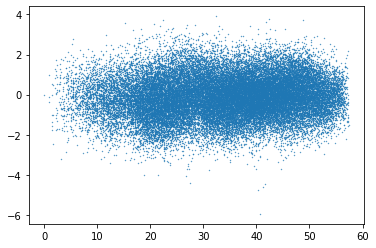

In [75]:
temp = zRresp[1500]
temp.shape

others = torch.from_numpy(temp-temp[0]).float()
othersloc = (loc-loc[0, :]).norm(dim=-1)


print(others.shape, othersloc.shape)
plt.scatter(othersloc, others, marker='.', s=0.5)